In [1]:
import mysql.connector
import os

In [4]:
db = mysql.connector.connect(
    host= 'localhost',
    user = 'root',
    password ='',
    database = ''
)

cur = db.cursor()

**Basic Queries**
1. List all unique cities where customers are located.
2. Count the number of orders placed in 2017.
3. Find the total sales per category.
4. Calculate the percentage of orders that were paid in installments.
5. Count the number of customers from each state. 


### 1.List all unique cities where customers are located.


In [13]:
query = """
    select distinct customer_city
    from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2.Count the number of orders placed in 2017.

In [14]:
query = """
select count(order_id) 
from orders
where year(order_purchase_timestamp)
"""
cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 99441)

### 3.Find the total sales per category

In [15]:
query = """
select products.product_category as category,sum(payment_value) as total_sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by category

"""
cur.execute(query)

data  = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,5.067387e+05
1,Furniture Decoration,1.430176e+06
2,telephony,4.868821e+05
3,bed table bath,1.712554e+06
4,automotive,8.522943e+05
...,...,...
69,cds music dvds,1.199430e+03
70,La Cuisine,2.913530e+03
71,Fashion Children's Clothing,7.856700e+02
72,PC Gamer,2.174430e+03


### 4.Calculate the percentage of orders that were paid in installments.

In [16]:
query = """
select (sum(case when payment_installments>= 1 then 1 else 0 end))/count(*)*100
from payments
"""

cur.execute(query)

data  = cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

### 5.Count the number of customers from each state.

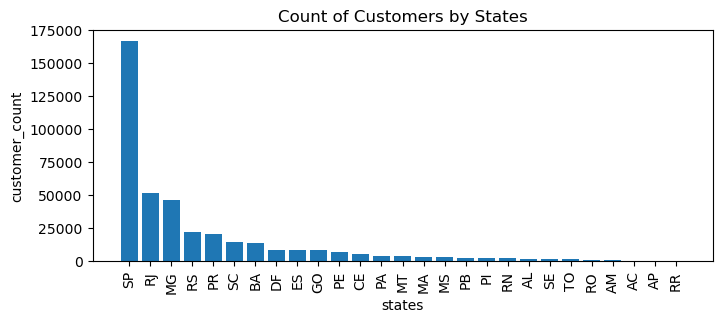

In [8]:
query = """
SELECT customer_state, COUNT(customer_id) AS no_of_customers
FROM customers
GROUP BY customer_state
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

**Intermediate Queries**
1. Calculate the number of orders per month in 2018.
2. Find the average number of products per order, grouped by customer city.
3. Calculate the percentage of total revenue contributed by each product category.
4. Identify the correlation between product price and the number of times a product has been purchased.
5. Calculate the total revenue generated by each seller, and rank them by revenue.

### 1.Calculate the number of orders per month in 2018.

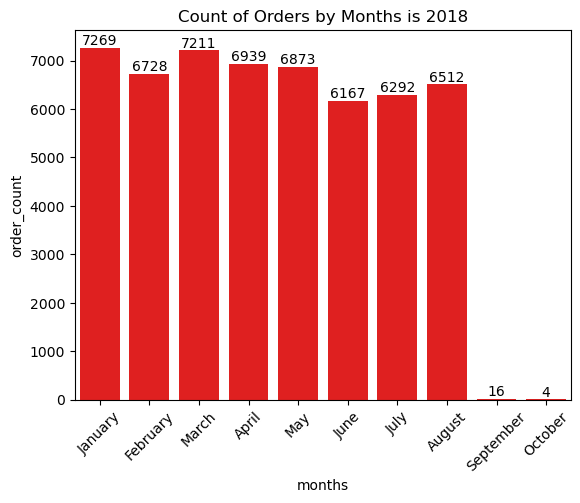

In [7]:
query = """
SELECT MONTHNAME(order_purchase_timestamp) AS month,COUNT(order_id) AS count
FROM orders
WHERE year(order_purchase_timestamp) =2018
GROUP BY month
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

### 2.Find the average number of products per order, grouped by customer city

In [6]:
query = """
WITH count_per_order as
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders join order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) AS average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC
"""
cur.execute(query)
data = cur.fetchall()
"The average number of products per order and grouped by customer city",data
df = pd.DataFrame(data, columns = ['customer_city','average_prod/orders'])
df.head()

,customer_city,average_prod/orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


### 3.Calculate the percentage of total revenue contributed by each product category.

In [12]:
query = """
SELECT products.product_category AS category, ROUND((SUM(payments.payment_value)/ (SELECT SUM(payment_value) FROM payments))*100,2) AS sales_percentage
FROM products JOIN order_items 
ON products.product_id = order_items.product_id
JOIN payments 
ON order_items.order_id = payments.order_id 
GROUP BY  category 
ORDER BY sales_percentage DESC 
"""
cur.execute(query)
data = cur.fetchall()
"The total revenue% contributed by each product category",data
df = pd.DataFrame(data, columns = ['Product_category','Sales%'])
df.head()

,Product_category,Sales%
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


### 4.Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """
SELECT upper(products.product_category) AS category , COUNT(order_items.product_id) AS order_counts,
ROUND(SUM(order_items.price),2) AS product_price
FROM products JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY category
ORDER BY order_counts DESC
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ['Product_category','order_counts','Product_price'])
df.head()
arr1 = df['order_counts']
arr2 = df['Product_price']
a = np.corrcoef([arr1,arr2])
"the correlation between product price and the number of times a product purchased",a[0][1]

('the correlation between product price and the number of times a product purchased',
 np.float64(0.9503301482940802))

### 5.Calculate the total revenue generated by each seller, and rank them by revenue.

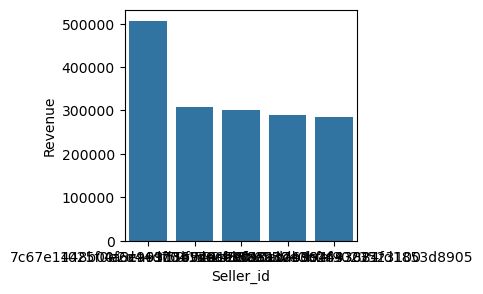

In [6]:
query = """
SELECT 
    seller,
    total_revenue,
    DENSE_RANK() OVER(ORDER BY total_revenue DESC) AS revenue_rank
FROM (
    SELECT 
        sellers.seller_id AS seller,
        SUM(payments.payment_value) AS total_revenue
    FROM sellers
    JOIN order_items 
        ON sellers.seller_id = order_items.seller_id
    JOIN payments 
        ON order_items.order_id = payments.order_id
    GROUP BY sellers.seller_id
) AS seller_revenue
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ['Seller_id','Revenue','Rank'])
df = df.head()
plt.figure(figsize = (3,3))
sns.barplot(x = "Seller_id",y = 'Revenue',data = df)
plt.show()


**Advanced Queries**
1. Calculate the moving average of order values for each customer over their order history.
2. Calculate the cumulative sales per month for each year.
3. Calculate the year-over-year growth rate of total sales.
4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
5. Identify the top 3 customers who spent the most money in each year.

### 1.Calculate the moving average of order values for each customer over their order history.

In [8]:
query = """
SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM ( 
SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value AS payment
FROM payments JOIN orders
ON payments.order_id = orders.order_id ) AS a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer_id','Timestamp','Price','Mov_avg'])

df.head()

,Customer_id,Timestamp,Price,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


### 2.Calculate the cumulative sales per month for each year

In [10]:
query = """
SELECT years, months, payment, SUM(payment)
OVER (ORDER BY years, months) AS cummulative_sales
FROM (
SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS  payment 
FROM orders JOIN payments ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months) AS a 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years','months','pauments','cummulative_sales'])
df.head()

,years,months,pauments,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


### 3.Calculate the year-over-year growth rate of total sales.

In [12]:
query = """
SELECT year,total_sales,
ROUND(((total_sales-LAG(total_sales,1) OVER (ORDER BY year ))/LAG(total_sales,1) OVER (ORDER BY year))*100,2) AS yoy_of_growth
 FROM
(SELECT YEAR(orders.order_purchase_timestamp) as year,
ROUND(SUM(payments.payment_value),2) AS total_sales
FROM orders JOIN payments ON orders.order_id = payments.order_id
GROUP BY year) a 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["years",'total_sales',"YOY_%_Growth"])
df

,years,total_sales,YOY_%_Growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


### 4.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [4]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

### 5.Identify the top 3 customers who spent the most money in each year

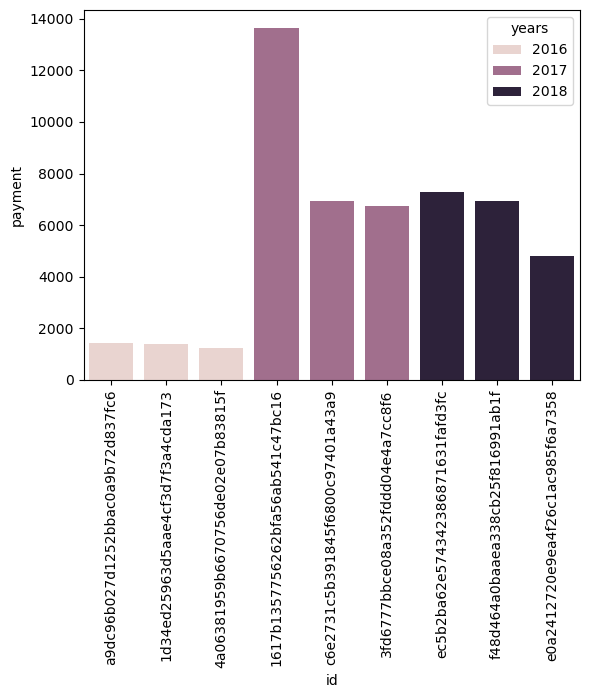

In [5]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()